# October 7, 2022: Near miss analysis

In [1]:
import os
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
from tqdm.notebook import tqdm
import pickle, random
import csv
from copy import deepcopy

from brainiak.isc import (
    compute_correlation
)

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/oct22"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils_v1 as dataset_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 74
np.random.seed(args.SEED)

args.APPR = 1
args.RETR = -1
args.LABELS = [None, args.APPR, args.RETR]
args.LABEL_NAMES = ['NEAR_MISS', 'APPR', 'RETR']
args.NAMES = ['NEAR_MISS', 'APPR', 'RETR']
args.TRIAL_LEN = 12
args.near_miss_thresh = [0.77, 0.88]
args.near_miss_width = 7.5
args.min_window_length = 12
args.window_shift = 3
args.TR = 1.25

In [3]:
args.proj_dir = proj_dir

# with open(
#     f"/home/joyneelm/FORAGING/local/notebooks/dynamical_systems_emoprox/emoprox_motion_parameters.pkl", 
#     'rb'
# ) as f:
#     motion_df = pickle.load(f)
# copied Joyneel's pkl file 
with open(
    f"/home/govindas/network_dynamics/data/emoprox2/data/emoprox_motion_parameters.pkl", 
    'rb'
) as f:
    motion_df = pickle.load(f)
# motion_df

args.roi_set_name = 'mashid'
args.main_data_dir = (
    f"{proj_dir}/data/emoprox2/data/rois_{args.roi_set_name}"
)

# exploratory data
args.subjects = np.unique(motion_df.pid.values)
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]

# ROIs
args = dataset_utils.get_mashid_rois(args)
args = dataset_utils.get_mashid_plot_tick_labels(args)

[13 12 12  8]
[13 25 37]
[ 7 19 31 41]
['Salience' 'Executive' 'Task negative' 'Subcortical']


In [4]:
def get_emo2_single_subj_stimulus_and_responses(args, subj, motion_df, segment_lens):
    def get_seg_trs(win_bdry, peak, name):
        if name == 'NEAR_MISS':
            seg_trs = np.arange(win_bdry[0], win_bdry[1]+1) # don't shift the window
        if name == 'APPR':
            seg_trs = np.arange(win_bdry[0], peak+1) #+ args.window_shift
        if name == 'RETR':
            seg_trs = np.arange(peak+1, win_bdry[1]+1) #+ args.window_shift

        return seg_trs

    x = {name:[] for name in args.NAMES}

    subj_motion_df = motion_df.loc[motion_df.pid.isin([subj])]
    proximity = np.hstack(
        subj_motion_df['proximity'].to_list()
    ).T
    direction = np.hstack(
        subj_motion_df['direction'].to_list()
    ).T
    ts = np.loadtxt(
        f"{args.main_data_dir}/CON{subj}/CON{subj}_resids_REML.1D"
    ).T

    assert (proximity.shape[0] == ts.shape[0])
    assert (direction.shape[0] == ts.shape[0])
    assert (np.sum(np.isnan(ts)) == 0)

    # censor proximity and direction 
    censor_TRs = ts[:,0] == 0
    proximity[censor_TRs] = 0.0
    direction[censor_TRs] = 0.0

    # near miss peaks
    near_miss_peaks, _ = signal.find_peaks(
        proximity, 
        height=args.near_miss_thresh, 
        width=args.near_miss_width
    )

    # mark all APPR followed by RETR segments
    # appending -1 so as to give a boundary point 
    # at the beginning of the stimulus; i.e. 1st run's, 1st TR
    diff_dir = np.diff(np.append(-1, direction))
    window_boundary_trs = np.where(
        (diff_dir > 0) | (diff_dir == -args.APPR)
    )[0]

    # (near miss, appr, retr) segments
    # between which boundary trs do near miss peaks lie?
    for peak in near_miss_peaks:
        win_bdry = np.array(
            (window_boundary_trs[window_boundary_trs < peak][-1],
            window_boundary_trs[window_boundary_trs > peak][0])
        )
        # print(win_bdry[0], peak, win_bdry[-1])
        if win_bdry[1] - win_bdry[0] + 1 <= args.min_window_length: continue

        segment_lens['NEAR_MISS'].append(win_bdry[-1] - win_bdry[0] + 1)
        segment_lens['APPR'].append(peak - win_bdry[0] + 1) 
        segment_lens['RETR'].append(win_bdry[-1] - peak)

        for name in args.NAMES:
            seg_trs = get_seg_trs(win_bdry, peak, name)
            x[name].append(ts[seg_trs, :])

    return (proximity, direction, near_miss_peaks, window_boundary_trs, diff_dir), segment_lens, x

In [5]:
def plot_stimulus(args, subj, proximity, direction, near_miss_peaks, window_boundary_trs, diff_dir):
    fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(20, 20), dpi=120)

    for idx in range(len(proximity) // 360):
        ax = axs[idx]

        if idx == 0: ax.set_title(f"subj {subj}")

        pr_run_idxs = np.arange(360) + idx*360
        pr = proximity[pr_run_idxs]
        ax.plot(
            pr,
            linewidth=3,
            label='prox'
        )

        for y in args.near_miss_thresh:
            ax.axhline(y, xmin=0, xmax=len(pr), color='grey')

        in_run_idxs = (near_miss_peaks >= idx*360) & (near_miss_peaks < (idx+1)*360)
        nm = near_miss_peaks[in_run_idxs]
        ax.scatter(
            nm % 360, 
            proximity[nm],
            s=100,
            color='red',
            label='near_miss'
        )

        dr = direction[pr_run_idxs]
        ax.plot(
            dr, 
            linewidth=3,
            color='orange',
            alpha=0.3
        )

        # ddir = diff_dir[pr_run_idxs]
        # ax.plot(
        #     ddir, 
        #     linewidth=3,
        #     color='green',
        #     alpha=0.5
        # )

        in_run_idxs = (window_boundary_trs >= idx*360) & (window_boundary_trs < (idx+1)*360)
        win_bdry = window_boundary_trs[in_run_idxs]
        ax.vlines(
            win_bdry% 360, ymin=0, ymax=1, 
            linestyles='dashed', colors='purple', linewidth=3,
            label='window \nboundary'
        )

        ax.legend()

In [6]:
def emo2_stimulus_and_responses(args, motion_df):
    segment_lens = {'NEAR_MISS':[], 'APPR':[], 'RETR':[]}
    for subj in args.explor_subjects[:]:
        (
            (proximity, direction, 
            near_miss_peaks, window_boundary_trs, diff_dir),
            segment_lens, x
        ) = get_emo2_single_subj_stimulus_and_responses(
            args, subj, motion_df, segment_lens,
        )

        # plot_stimulus(
        #     args, subj, 
        #     proximity, direction, 
        #     near_miss_peaks, window_boundary_trs, diff_dir
        # )

    return segment_lens

In [7]:
segment_lens = emo2_stimulus_and_responses(args, motion_df)

## plot segment lengths

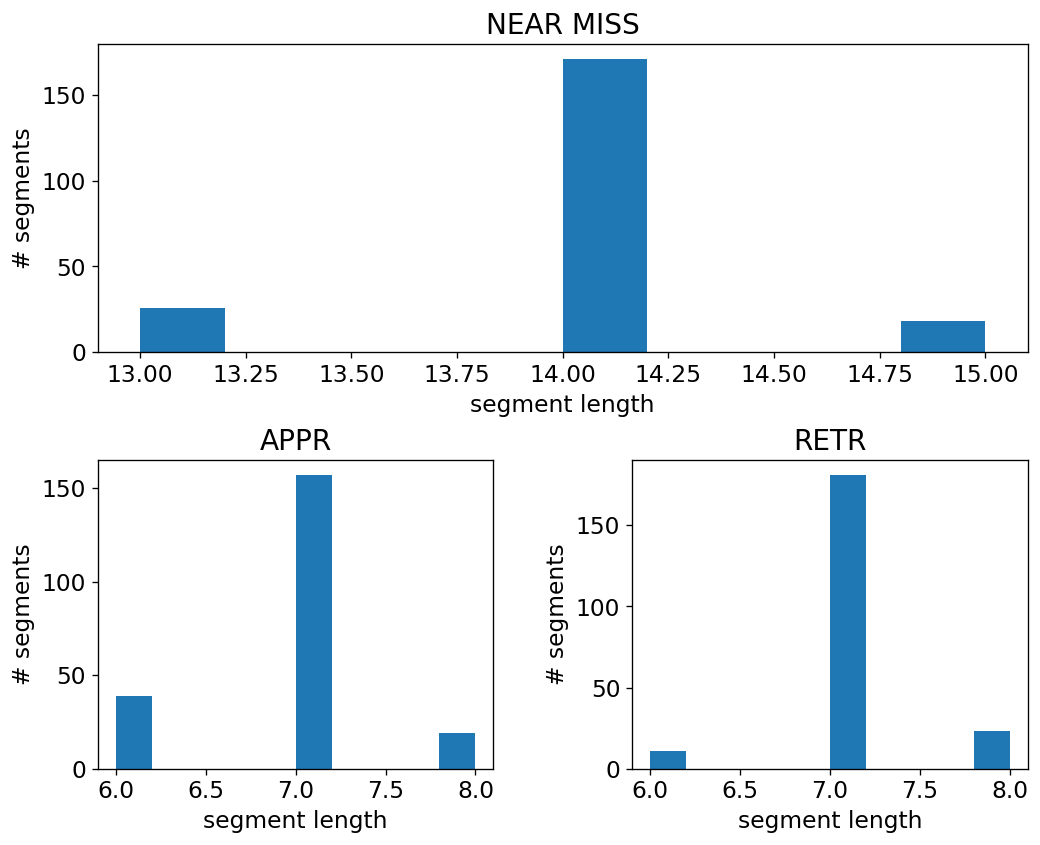

In [8]:
def plot_segment_lengths(args, segment_lens):
    nrows, ncols = 2, 2
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=False, 
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=0.35, hspace=0.35
    )

    gs = axs[0,0].get_gridspec()
    for i in [0,1]: axs[0, i].remove()
    ax = fig.add_subplot(gs[0, :])
    ax.hist(segment_lens['NEAR_MISS'], bins=10)
    ax.set_title('NEAR MISS')
    ax.set_ylabel('# segments')
    ax.set_xlabel('segment length')

    for idx, name in enumerate(args.NAMES[1:]):
        ax = axs[1, idx]

        ax.set_title(name)
        ax.hist(segment_lens[name], bins=10)
        ax.set_ylabel('# segments')
        ax.set_xlabel('segment length')

plot_segment_lengths(args, segment_lens)